In [1]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gns_utils import split_dataframe, csv_log_to_dataframe

In [2]:
pd.options.mode.chained_assignment = None
DATA_DIR = Path("3_time_intervals/results")
VIS_DIR = Path("3_time_intervals/visuals")

## Collect all experiment results

In [3]:
data = pd.concat(
    [csv_log_to_dataframe(DATA_DIR / file) 
    for file in os.listdir(DATA_DIR) if ".csv" in file],
    ignore_index=True
)
data["model"] = data["model"].apply(lambda x: int(x.strip(".pt")))
data.rename(columns={"model": "training_step"})

data

,model,true_portion,diff_steps,B,b,reps,t_min,t_max,accumulate,epoch,...,ckpt_dir,vis_dir,save_fig,date,gns_est,g_norm,b_true,runtime (s),user,host
0,90000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 16:59:29,8000.609863,0.023219,5000,269.954519,cimsir,diorit.cip.ifi.lmu.de
1,90000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:12:14,4375.177246,0.023826,5000,269.936655,cimsir,diamiktit.cip.ifi.lmu.de
2,80000,0.1,1000,5000,50,2,0,100,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:36:09,10358.764648,0.026551,5000,268.755545,cimsir,diorit.cip.ifi.lmu.de
3,80000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:45:18,544.148010,0.027077,5000,267.178063,cimsir,diorit.cip.ifi.lmu.de
4,80000,0.1,1000,5000,50,2,301,400,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 17:49:51,539.492859,0.022269,5000,268.653490,cimsir,diorit.cip.ifi.lmu.de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,80000,0.1,1000,5000,50,2,901,1000,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:43:51,8.516977,0.013595,5000,274.328680,cimsir,basalt.cip.ifi.lmu.de
251,80000,0.1,1000,5000,50,2,801,900,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:45:42,12.934482,0.014062,5000,299.964664,cimsir,arkose.cip.ifi.lmu.de
252,80000,0.1,1000,5000,50,2,901,1000,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:50:48,9.293446,0.013586,5000,300.777975,cimsir,arkose.cip.ifi.lmu.de
253,90000,0.1,1000,5000,50,2,201,300,True,False,...,checkpoints,/home/c/cimsir/GenAI_Practical/gns_experiments...,NaN,2025-01-31 11:57:57,1225.715454,0.020759,5000,272.741052,cimsir,basalt.cip.ifi.lmu.de


In [4]:
df_counts = data.groupby(["model", "t_min", "t_max"]).count()["gns_est"].reset_index()
df_counts

,model,t_min,t_max,gns_est
0,10000,0,100,4
1,10000,101,200,2
2,10000,201,300,3
3,10000,301,400,2
4,10000,401,500,1
...,...,...,...,...
72,80000,601,700,4
73,80000,701,800,3
74,80000,801,900,4
75,80000,901,1000,4


## Visualize GNS Evolution over Time and Training Steps

In [5]:
def plot_gns_time_intervals(data: pd.DataFrame, log_scale=False, fill_val=0, xlim = None, save_fig = None):
    ## Get gns values on intervals
    df_list = []
    for model in sorted(set(data["model"])):
        df = data[data["model"] == model].sort_values("t_min")
        df = df[["model", "t_min", "t_max", "gns_est"]]
        df = df.groupby(["model", "t_min", "t_max"]).mean()
            
            ## Fill missing values (with 0)
        intervals = pd.DataFrame({
            "model": [model for _ in range(10)],
            "t_min": sorted(data["t_min"].unique()),
            "t_max": sorted(data["t_max"].unique()),
        })
        df = intervals.merge(df.reset_index(), on=["model", "t_min", "t_max"], how="left").fillna(fill_val)
        df.set_index(["t_min", "t_max"], inplace=True)
        df_list.append(df)
    
    ## Plot each DataFrame as a horizontal bar plot
    print(f"Missing values (of time-intervals) are filled with '{fill_val}'\n")
    fig, axes = plt.subplots(1, len(df_list), figsize=(20, 5), sharey=True)
    fig.suptitle(f"Average GNS over Time/Training ({'log' if log_scale else 'linear'}-scale)", fontsize=24)
    fig.supxlabel("Training Steps", fontsize=20)
    
    for i, (df, ax) in enumerate(zip(df_list, axes)):
        df.drop("model", axis=1, inplace=True)
        df.plot.barh(ax=ax, legend=False)
        ax.set_title(f"Step {sorted(set(data['model']))[i]}")
        ax.set_xlabel("gns", fontsize=12)
        ax.set_ylabel("t_min / t_max", fontsize=12)
        if log_scale:
            ax.set_xscale("log")
        if xlim is not None:
            ax.set_xlim(xlim)
        
    ## Plot & save
    plt.tight_layout()
    if save_fig is not None:
        plt.savefig(save_fig)
    
    plt.show()

In [6]:
def plot_over_training_steps(data: pd.DataFrame, log_scale=True, save_fig=None):
    df = data[["model", "t_min", "t_max", "gns_est"]]
    df = df.groupby(["model", "t_min", "t_max"]).mean().reset_index()
    df["interval"] = list(zip(df["t_min"], df["t_max"]))
    df = df.drop(["t_min", "t_max"], axis=1)
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Avg. Time-Bin GNS over Training ({'log' if log_scale else 'linear'}-scale)", fontsize=24)
    for i, intv in enumerate(df["interval"].unique()):
        df_intv = df[df["interval"] == intv].reset_index().drop(["index", "interval"], axis=1)
        plt.plot(df_intv["model"], df_intv["gns_est"], marker="o", label=str(intv))
        
    if log_scale:
        plt.yscale("log")
        
    plt.xlabel("Training Step")
    plt.ylabel("Gradient Noise Scale")
    plt.legend()
    
    if save_fig is not None:
        plt.savefig(save_fig)
    
    plt.plot()

#### Plot in linear-scale:

Missing values (of time-intervals) are filled with '0'



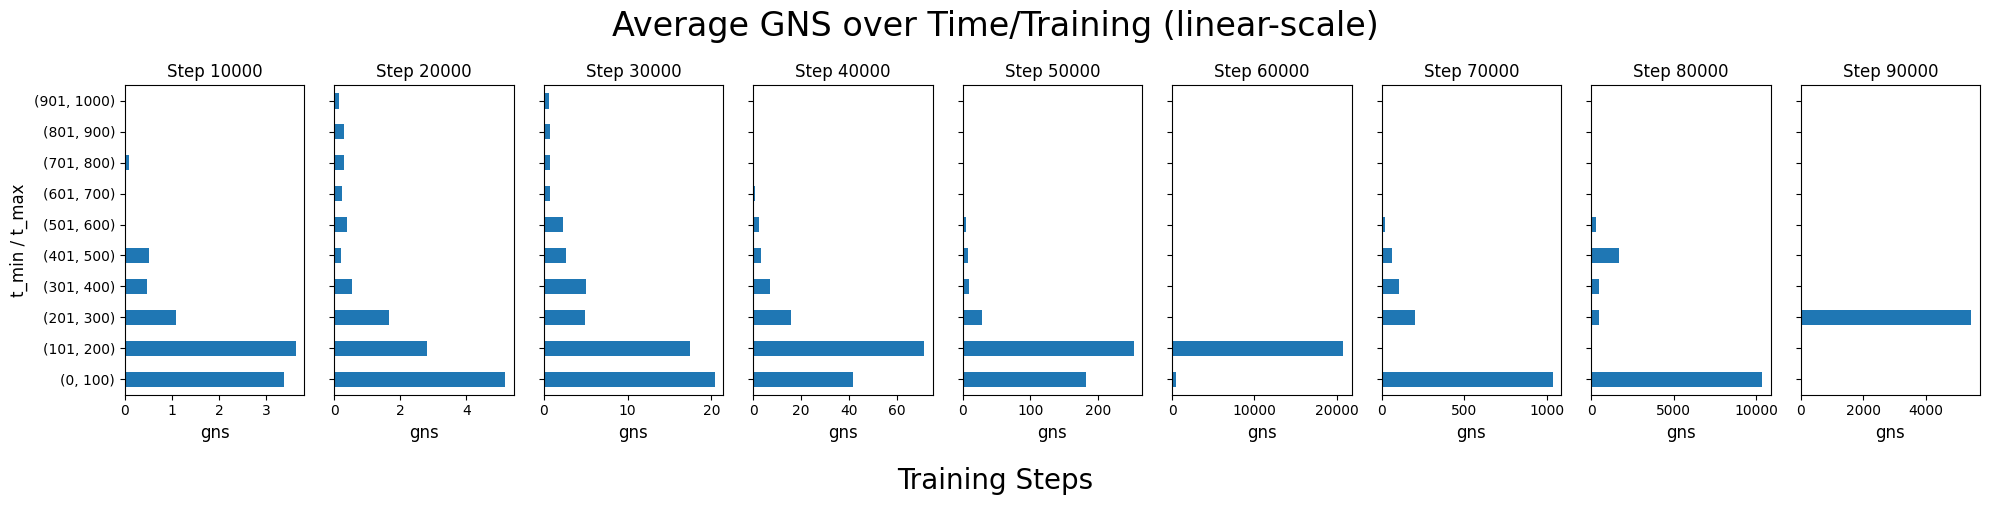

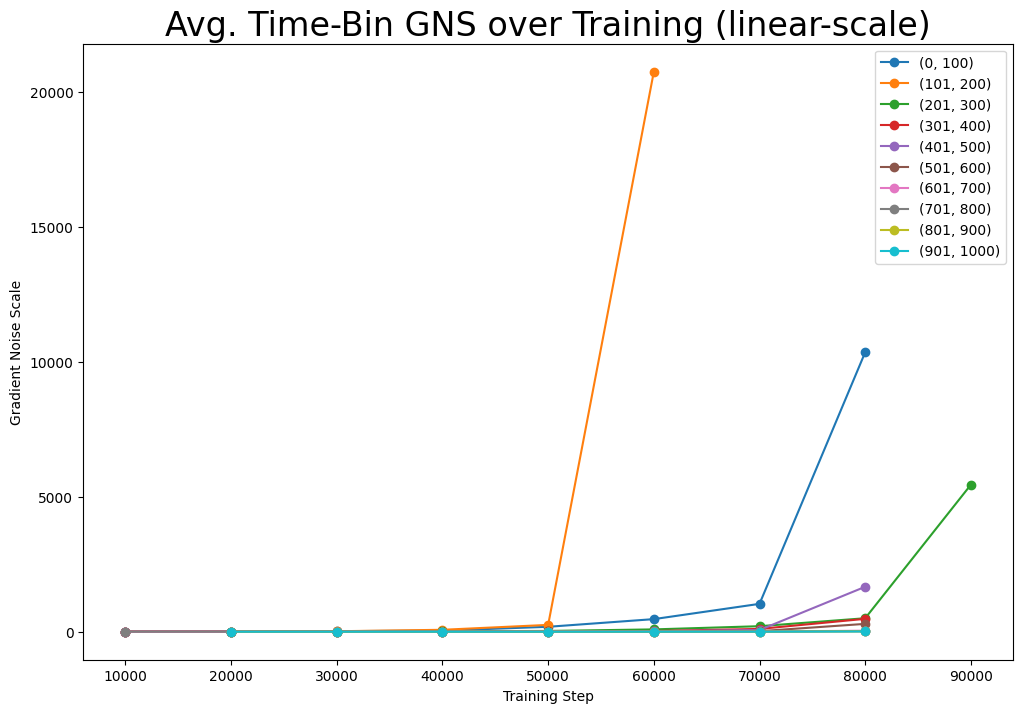

In [7]:
plot_gns_time_intervals(data, log_scale=False)
plot_over_training_steps(data, log_scale=False)

### Plot in logarithmic-scale:

Missing values (of time-intervals) are filled with '0'



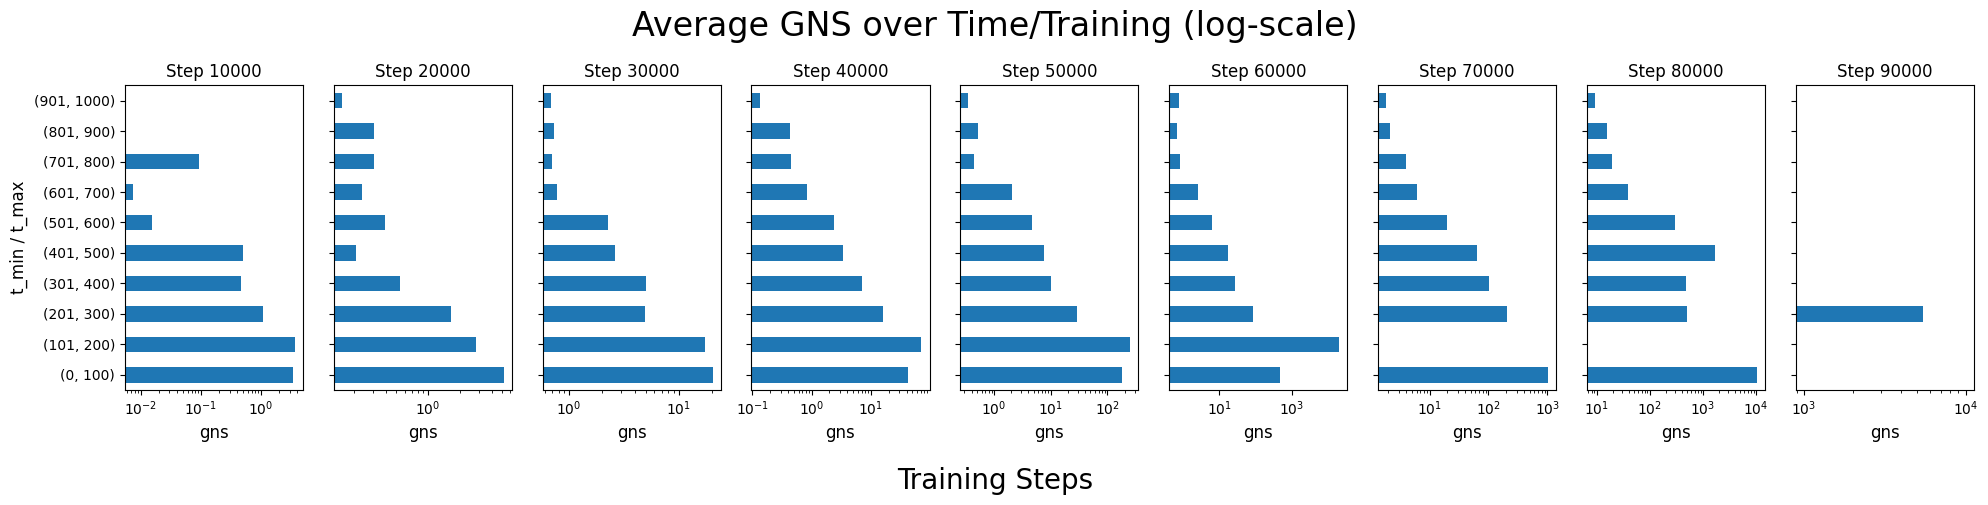

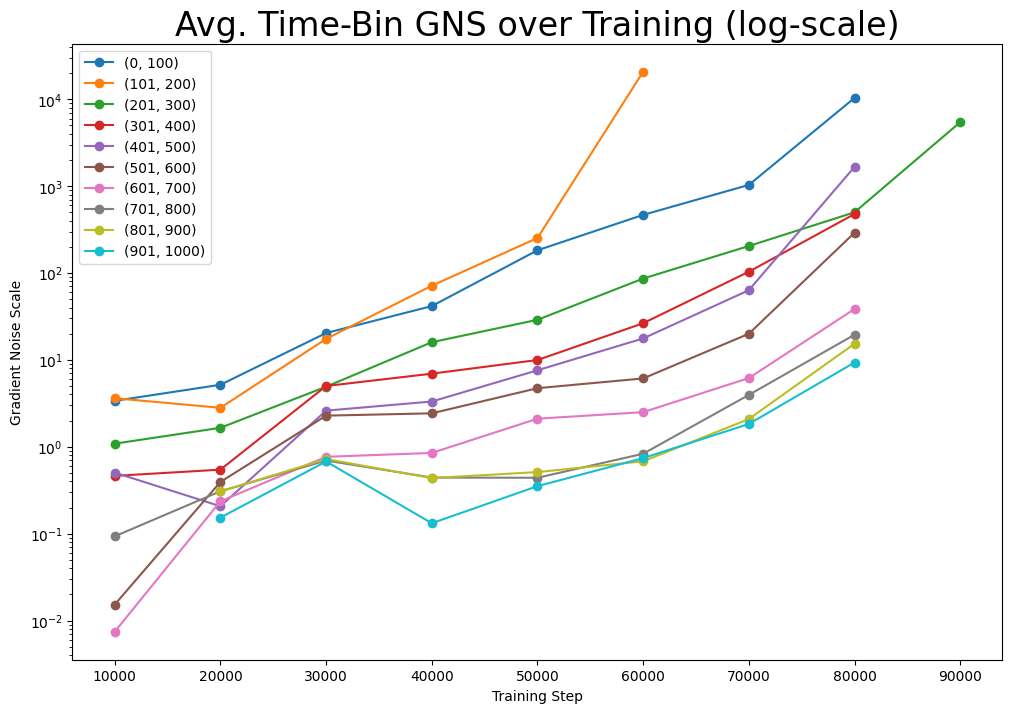

In [8]:
plot_gns_time_intervals(data, log_scale=True)
plot_over_training_steps(data, log_scale=True)

## 

In [9]:
df = data[["model", "t_min", "t_max", "gns_est"]]
df = df.groupby(["model", "t_min", "t_max"]).mean().reset_index()
df["interval"] = list(zip(df["t_min"], df["t_max"]))
df = df.drop(["t_min", "t_max"], axis=1)

intervals = df["interval"].unique()[::-1]